<a href="https://colab.research.google.com/github/tanisha1112/ECE_792_Assignments/blob/main/ECE_792_hw04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from torch.utils.data import Dataset,DataLoader
from torch import optim
from torch.autograd import Variable
from torch.distributions.multivariate_normal import MultivariateNormal
from IPython import embed

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = np.array([self.data.iloc[idx, 1], self.data.iloc[idx, 2]])
        return x

In [ ]:
folder_path = '/content/drive/MyDrive/ECE_792_HW4_dataset/'
circles_train_path = folder_path + 'circles_train.csv'
circles_test_path = folder_path + 'circles_test.csv'
moon_train_path = folder_path + 'moons_train.csv'
moon_test_path = folder_path + 'moons_test.csv'

In [ ]:
circles_trainset = CustomDataset(circles_train_path)
circles_testset = CustomDataset(circles_test_path)

In [ ]:
circles_trainset[0]

array([ 0.05729734, -0.5188567 ])

In [ ]:
circles_testset[0]

array([-1.0186423 , -0.25429198])

In [ ]:
def plot_dataset(dataset):
  scatter_list =[]
  for cords in dataset:
    scatter_list.append(cords)
  # print(scatter_list)
  plt.scatter(*zip(*scatter_list),s=5, alpha=0.5)
  plt.show()

In [ ]:
len(circles_trainset)

4250

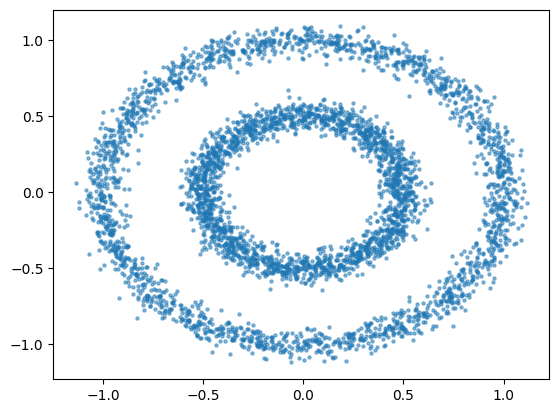

In [ ]:
plot_dataset(circles_trainset)

In [ ]:
moons_trainset = CustomDataset(moon_train_path)
moons_testset = CustomDataset(moon_test_path)

In [ ]:
moons_trainset[0]

array([ 1.7887566 , -0.15627375])

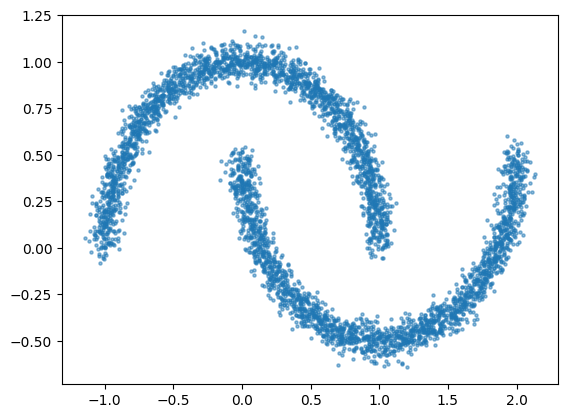

In [ ]:
plot_dataset(moons_trainset)

In [ ]:
batch_size = 128
circles_trainloader = DataLoader(circles_trainset, batch_size=batch_size, shuffle=True)
circles_testloader = DataLoader(circles_testset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_size = 128
moons_trainloader = DataLoader(moons_trainset, batch_size=batch_size, shuffle=True)
moons_testloader = DataLoader(moons_testset, batch_size=batch_size, shuffle=True)

In [ ]:
mean = torch.zeros(2)
covariance = torch.eye(2)

# Create a PyTorch MultivariateNormal distribution
z_dist = MultivariateNormal(mean, covariance)

In [ ]:
def plot_z_dist(z_dist, num_samples):
  samples = z_dist.sample((num_samples,)).numpy()
  plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
  plt.show()

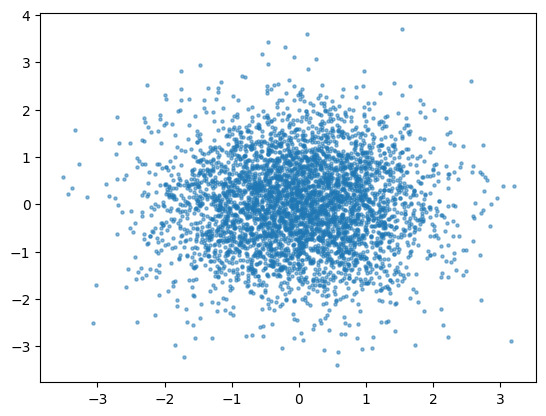

In [ ]:
plot_z_dist(z_dist,len(circles_trainset))

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, in_features, out_features, num_features):  # num_features of hidden layers
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(in_features, num_features),
          nn.LeakyReLU(0.2),
          nn.Linear(num_features, num_features),
          nn.LeakyReLU(0.2),
          nn.Linear(num_features, num_features),
          nn.LeakyReLU(0.2),
          nn.Linear(num_features, out_features),
      )
  def forward(self, x):
      return self.net(x)

In [ ]:
class AffineCouplingLayer(nn.Module):
  def __init__(self, dim, parity, net_class=NeuralNet, num_features = 1024):
    super().__init__()
    self.dim = dim
    self.parity = parity           # parity decides which split dimension to take
    self.scaling = net_class(self.dim // 2, self.dim // 2, num_features)         # in_features = 1, out_features =1 , num_features = 24
    self.translation = net_class(self.dim // 2, self.dim // 2, num_features)       # in_features = 1, out_features =1 , num_features = 24

  def forward(self, x):
      # print("AffineCouplingLayer")
      x0, x1 = x[:,::2], x[:,1::2]     #split dimension into 2
      if self.parity:         # if 1 parity: order is switched
          x0, x1 = x1, x0
      x0 = x0.to(torch.float32)
      x1 = x1.to(torch.float32)
      s = self.scaling(x0)
      t = self.translation(x0)
      z0 = x0 # untouched half
      z1 = torch.exp(s) * x1 + t # bijective transformation on this half
      if self.parity:
          z0, z1 = z1, z0
      z = torch.cat([z0, z1], dim=1)
      log_det = torch.sum(s, dim=1)      #log-determinant of the Jacobian matrix
      return z, log_det

  def backward(self, z):            #inverse operation
      z0, z1 = z[:,::2], z[:,1::2]
      if self.parity:
          z0, z1 = z1, z0
      s = self.scaling(z0)
      t = self.translation(z0)
      x0 = z0 # this was the same
      x1 = (z1 - t) * torch.exp(-s) # reverse the transform on this half
      if self.parity:
          x0, x1 = x1, x0
      x = torch.cat([x0, x1], dim=1)
      log_det = torch.sum(-s, dim=1)
      return x, log_det

In [ ]:
class NormalizingFlow(nn.Module):
  def __init__(self, flows):
    super().__init__()
    self.flows = nn.ModuleList(flows)

  def forward(self, x):
    # print("NormalizingFlow")
    m, _ = x.shape
    flows_log_det = torch.zeros(m)
    zs = [x]
    for flow in self.flows:
      x, log_det = flow.forward(x)
      flows_log_det += log_det
      zs.append(x)
    return zs, flows_log_det

  def backward(self, z):
    m, _ = z.shape
    flows_log_det = torch.zeros(m)
    xs = [z]
    for flow in self.flows[::-1]:
        z, log_det = flow.backward(z)
        flows_log_det += log_det
        xs.append(z)
    return xs, flows_log_det

In [ ]:
class NormalizingFlowModel(nn.Module):
  def __init__(self, z_dist, flows):
    super().__init__()
    self.z_dist = z_dist
    self.flow = NormalizingFlow(flows)

  def forward(self, x):
    # print("NormalizingFlowModel")
    zs, log_det = self.flow.forward(x)
    z_logprob = self.z_dist.log_prob(zs[-1]).view(x.size(0), -1).sum(1) #The log probability of the transformed data points of last coupling layer
    return zs, z_logprob, log_det

  def backward(self, z):
    xs, log_det = self.flow.backward(z)
    return xs, log_det

  def sample(self, num_samples):
    z = self.z_dist.sample((num_samples,))
    xs, _ = self.flow.backward(z)
    return xs

##  1 Affine Coupling layer model

In [ ]:
flows = [AffineCouplingLayer(dim=2, parity=i%2) for i in range(1)]  #mixing at each coupling layer

In [ ]:
model = NormalizingFlowModel(z_dist, flows)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
model.train()
num_epochs = 10
total_loss = []
for epochs in range(num_epochs):
  running_loss = 0
  for batch_idx, x in enumerate(circles_trainloader):
    zs, z_logprob, log_det = model(x)
    logprob = z_logprob + log_det
    loss = -torch.sum(logprob) #negative log-likelihood of the data to minimize the loss

    model.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % num_epochs == 0:
        print(loss.item())
    running_loss += loss.item()
  epoch_loss = running_loss / len(circles_trainloader)
  total_loss.append(epoch_loss)

277.01593017578125
244.3828125
244.10394287109375
243.9117431640625
245.3736114501953
242.17025756835938
243.1097869873047
233.33578491210938
233.4563751220703
239.75335693359375
240.24639892578125
240.2099609375
231.8114013671875
247.6068115234375
242.76751708984375
236.1480712890625
243.97337341308594
240.75172424316406
238.79322814941406
246.33193969726562
236.162353515625
245.82872009277344
242.55520629882812
232.2991180419922
237.970947265625
239.5960235595703
238.14144897460938
236.06553649902344
239.65036010742188
243.743408203125
241.66893005371094
240.13734436035156
236.1026611328125
238.3083953857422
240.64605712890625
237.2176971435547
232.28919982910156
237.84982299804688
244.33367919921875
247.51576232910156


In [ ]:
model.eval()
all_x_points= []
all_z_points = []
for batch_idx, x in enumerate(circles_testloader):
  zs, z_logprob, log_det = model(x)
  logprob = z_logprob + log_det
  all_x_points.append(x.detach().numpy())
  all_z_points.append(zs[-1].detach().numpy()) #last coupling layer

In [ ]:
all_x_points = np.concatenate(all_x_points)
all_z_points = np.concatenate(all_z_points)

In [ ]:
print(len(all_x_points),len(all_z_points))

750 750


In [ ]:
total_loss

[241.7654519922593,
 236.1056214500876,
 235.7727953966926,
 235.60886966480928,
 235.29647266163545,
 234.86147229811723,
 234.4822438183953,
 233.96475488999312,
 233.63904975442324,
 233.13551712036133]

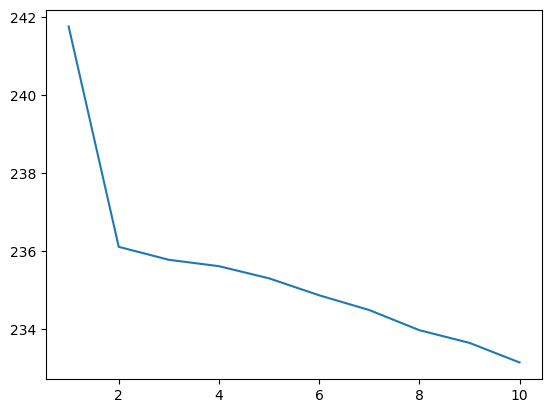

In [ ]:
epochs = list(range(1, num_epochs+1))
plt.plot(epochs,total_loss)
plt.show()

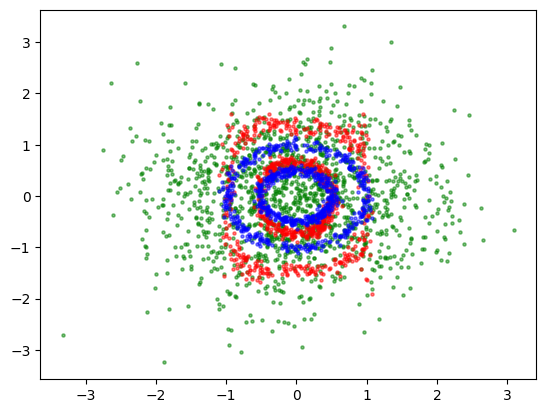

In [ ]:
gauss = model.z_dist.sample([len(all_x_points), 2]).squeeze()
plt.scatter(gauss[:,0], gauss[:,1], c='g', s=5, alpha=0.5)
plt.scatter(all_z_points[:,0], all_z_points[:,1], c='r', s=5, alpha=0.5)
plt.scatter(all_x_points[:,0], all_x_points[:,1], c='b', s=5, alpha=0.5)

750 750


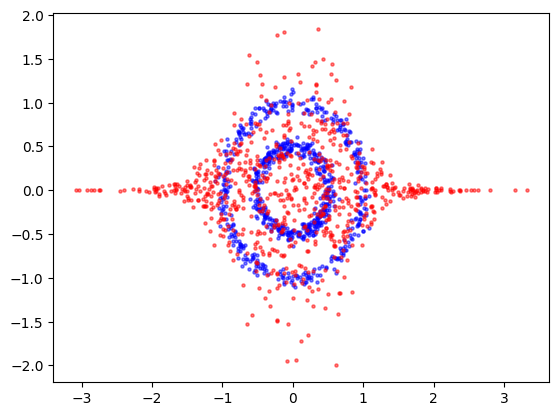

In [ ]:
zs = model.sample(len(all_x_points))
z = zs[-1]
z = z.detach().numpy()
print(len(all_x_points),len(z))
plt.scatter(all_x_points[:,0], all_x_points[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)

In [ ]:
model.train()
num_epochs = 10
total_loss = []
for epochs in range(num_epochs):
  running_loss = 0
  for batch_idx, x in enumerate(moons_trainloader):
    zs, z_logprob, log_det = model(x)
    logprob = z_logprob + log_det
    loss = -torch.sum(logprob) #negative log-likelihood of the data to minimize the loss

    model.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % num_epochs == 0:
        print(loss.item())
    running_loss += loss.item()
  epoch_loss = running_loss / len(moons_trainloader)
  total_loss.append(epoch_loss)

3149.14013671875
318.0093994140625
297.6080627441406
239.4449920654297
244.50167846679688
230.6281280517578
238.68478393554688
232.53756713867188
222.20150756835938
218.6418914794922
230.0584716796875
218.53903198242188
224.33538818359375
225.92660522460938
220.22991943359375
243.45008850097656
231.73965454101562
218.6912078857422
219.1380157470703
223.19888305664062
220.579345703125
205.11012268066406
208.2455596923828
217.6692657470703
212.2432098388672
205.97927856445312
210.4985809326172
213.59686279296875
205.2472381591797
206.4224853515625
213.60354614257812
208.7034149169922
200.81675720214844
208.21218872070312
213.1982421875
191.74896240234375
189.41552734375
206.46226501464844
203.62887573242188
208.75184631347656


In [ ]:
model.eval()
all_x_points= []
all_z_points = []
for batch_idx, x in enumerate(moons_testloader):
  zs, z_logprob, log_det = model(x)
  logprob = z_logprob + log_det
  all_x_points.append(x.detach().numpy())
  all_z_points.append(zs[-1].detach().numpy()) #last coupling layer
all_x_points = np.concatenate(all_x_points)
all_z_points = np.concatenate(all_z_points)

print(len(all_x_points),len(all_z_points))

750 750


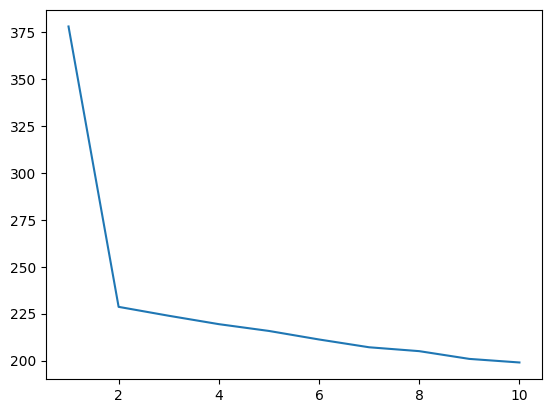

In [ ]:
epochs = list(range(1, num_epochs+1))
plt.plot(epochs,total_loss)
plt.show()

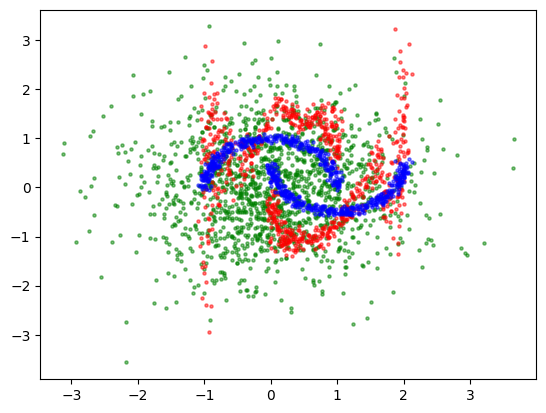

In [ ]:
gauss = model.z_dist.sample([len(all_x_points), 2]).squeeze()
plt.scatter(gauss[:,0], gauss[:,1], c='g', s=5, alpha=0.5)
plt.scatter(all_z_points[:,0], all_z_points[:,1], c='r', s=5, alpha=0.5)
plt.scatter(all_x_points[:,0], all_x_points[:,1], c='b', s=5, alpha=0.5)

750 750


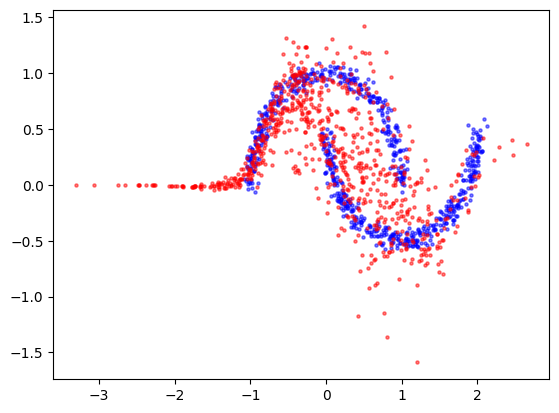

In [ ]:
zs = model.sample(len(all_x_points))
z = zs[-1]
z = z.detach().numpy()
print(len(all_x_points),len(z))
plt.scatter(all_x_points[:,0], all_x_points[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)

##  3 Affine Coupling layer model

In [ ]:
def combined_plots(layers, train_dataloader, test_dataloader, num_epochs):
  flows = [AffineCouplingLayer(dim =2, parity=i%2) for i in range(layers)]  #mixing at each coupling layer
  model = NormalizingFlowModel(z_dist, flows)
  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
  model.train()
  total_loss = []
  for epochs in range(num_epochs):
    running_loss = 0
    for batch_idx, x in enumerate(train_dataloader):
      zs, z_logprob, log_det = model(x)
      logprob = z_logprob + log_det
      loss = -torch.sum(logprob) #negative log-likelihood of the data to minimize the loss

      model.zero_grad()
      loss.backward()
      optimizer.step()
      if batch_idx % num_epochs == 0:
          print(loss.item())
      running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    total_loss.append(epoch_loss)
  model.eval()
  all_x_points= []
  all_z_points = []
  for batch_idx, x in enumerate(test_dataloader):
    zs, z_logprob, log_det = model(x)
    logprob = z_logprob + log_det
    all_x_points.append(x.detach().numpy())
    all_z_points.append(zs[-1].detach().numpy()) #last coupling layer
  all_x_points = np.concatenate(all_x_points)
  all_z_points = np.concatenate(all_z_points)

  print(len(all_x_points),len(all_z_points))

  epochs = list(range(1, num_epochs+1))
  plt.plot(epochs,total_loss)
  plt.show()


  zs = model.sample(len(all_x_points))
  z = zs[-1]
  z = z.detach().numpy()
  plt.scatter(all_x_points[:,0], all_x_points[:,1], c='b', s=5, alpha=0.5)
  plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
  plt.show()


326.7252197265625
231.01028442382812
209.61624145507812
209.3114776611328
204.74085998535156
200.75619506835938
195.0457000732422
189.3993377685547
185.3636932373047
177.7214813232422
178.95352172851562
181.89947509765625
171.6234893798828
165.8167266845703
161.81040954589844
159.8571014404297
168.31248474121094
181.75364685058594
155.88377380371094
160.8809356689453
150.15036010742188
140.29876708984375
152.64288330078125
139.3017120361328
136.54360961914062
145.92852783203125
219.83804321289062
158.26400756835938
162.16796875
161.79795837402344
132.94976806640625
130.67897033691406
139.45106506347656
140.90145874023438
128.22938537597656
109.87435913085938
128.0665283203125
128.7288360595703
114.4177017211914
104.49693298339844
750 750


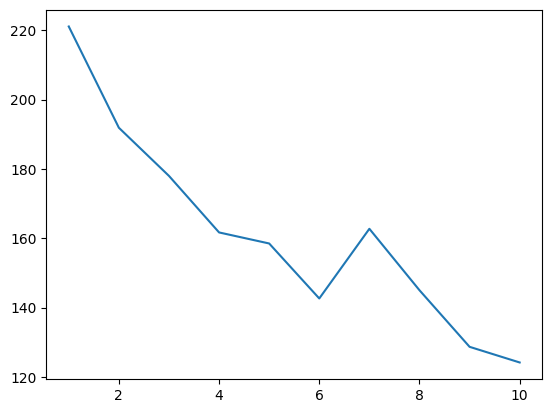

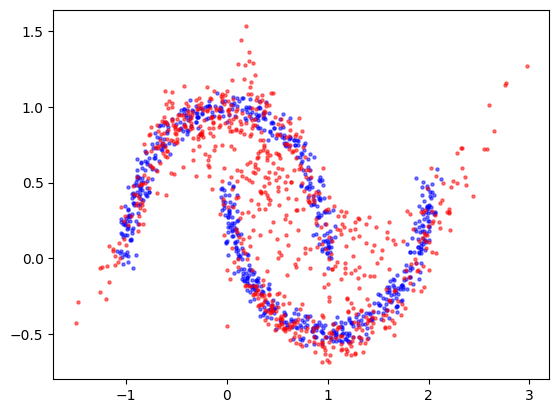

In [ ]:
layers =3
num_epochs = 10
combined_plots(layers,moons_trainloader, moons_testloader, num_epochs)

279.9295959472656
219.959716796875
208.51385498046875
207.885498046875
204.02432250976562
213.23460388183594
213.1721954345703
213.259521484375
206.94454956054688
209.39407348632812
195.4373016357422
212.5558624267578
211.28347778320312
204.73609924316406
210.1706085205078
207.05548095703125
201.19264221191406
195.42181396484375
204.97471618652344
195.9628448486328
194.35740661621094
192.54869079589844
199.09100341796875
195.3490753173828
193.37852478027344
194.60264587402344
194.5022430419922
185.1472930908203
185.72325134277344
180.7186737060547
188.6069793701172
195.27899169921875
194.06109619140625
194.49510192871094
191.6153564453125
192.81008911132812
191.962890625
187.8187713623047
188.20021057128906
180.53744506835938
750 750


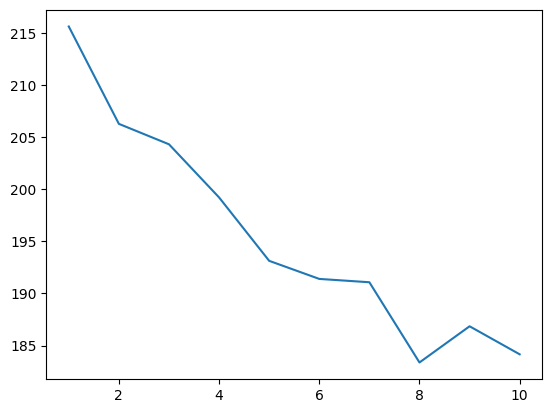

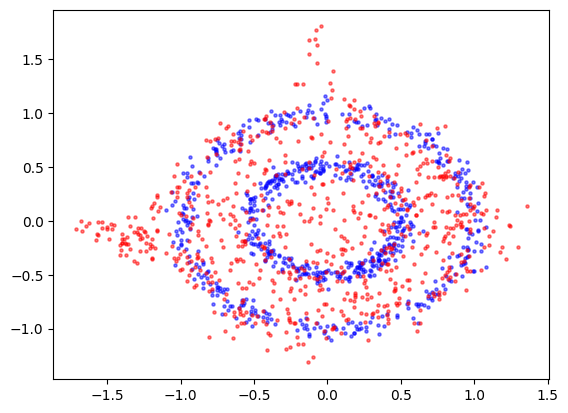

In [ ]:
layers =3
num_epochs = 10
combined_plots(layers,circles_trainloader, circles_testloader, num_epochs)

##  **5** Affine Coupling layer model

271.3291931152344
227.2284393310547
210.9744110107422
219.27847290039062
202.27044677734375
218.61044311523438
216.5992431640625
204.32542419433594
195.18441772460938
193.72518920898438
193.89669799804688
199.11434936523438
196.02810668945312
190.19796752929688
197.624755859375
189.02688598632812
187.0547637939453
194.13259887695312
189.5911865234375
194.3771209716797
193.7793426513672
188.79910278320312
182.0838623046875
220.49237060546875
203.51327514648438
194.41893005371094
192.8397979736328
189.65655517578125
191.32107543945312
188.06085205078125
202.80142211914062
199.1697540283203
197.74642944335938
195.26683044433594
203.34344482421875
198.4844512939453
197.96563720703125
188.6835174560547
191.2115020751953
186.3756561279297
750 750


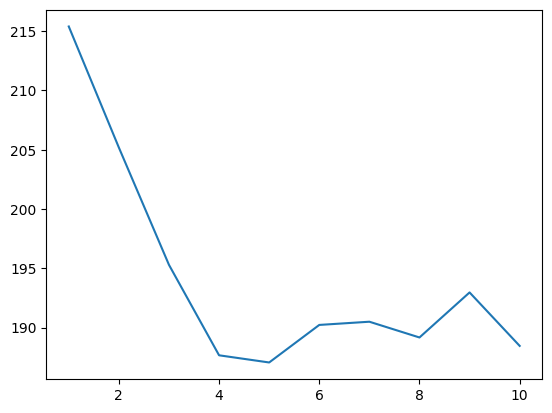

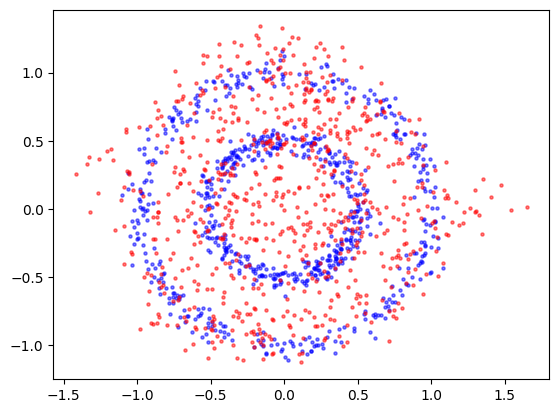

In [ ]:
layers =5
num_epochs = 10
combined_plots(layers,circles_trainloader, circles_testloader, num_epochs)

324.8854064941406
224.52633666992188
214.81793212890625
203.2669677734375
199.2361602783203
187.41281127929688
178.0277557373047
164.60411071777344
160.045654296875
157.48289489746094
139.9951171875
176.12892150878906
174.23709106445312
126.96034240722656
122.76295471191406
110.49404907226562
106.92249298095703
116.47783660888672
117.26211547851562
123.64437103271484
143.08131408691406
111.38534545898438
102.29150390625
102.29327392578125
107.65550231933594
95.23812103271484
92.38619232177734
103.96336364746094
105.90418243408203
87.9315185546875
91.69111633300781
101.38113403320312
122.31832885742188
59.16706085205078
72.55551147460938
68.83448028564453
150.17550659179688
103.72513580322266
65.62342834472656
71.65155792236328
750 750


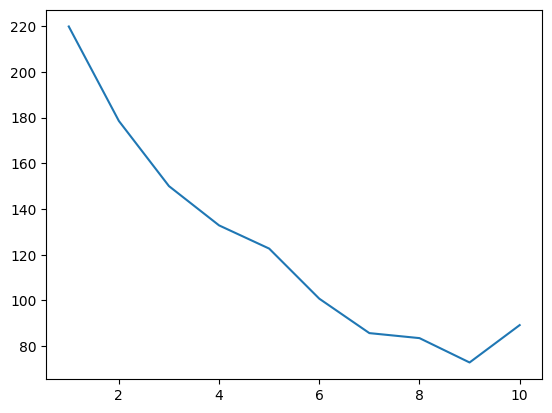

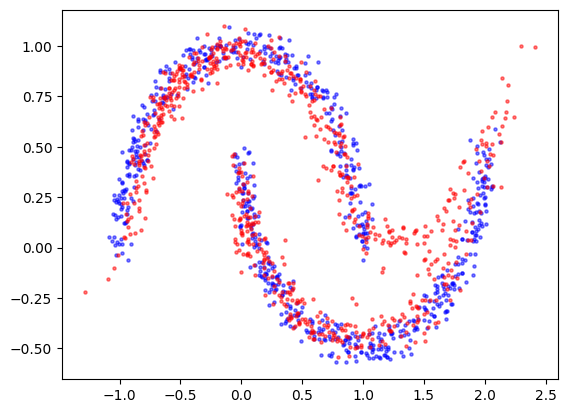

In [ ]:
layers =5
num_epochs = 10
combined_plots(layers,moons_trainloader, moons_testloader, num_epochs)

## Changing num_features in hidden layers and num epochs in 5 layer coupling


333.3948059082031
222.35855102539062
209.70411682128906
197.73138427734375
174.17269897460938
203.54266357421875
260.8973388671875
149.11370849609375
273.9141845703125
157.08377075195312
144.53013610839844
160.79052734375
209.81321716308594
160.99700927734375
927.3673706054688
283.29638671875
241.90484619140625
193.10595703125
357.1917724609375
280.1806335449219
211.8889923095703
177.3957061767578
170.6427001953125
171.43873596191406
179.78387451171875
156.5805206298828
171.80154418945312
416.1405944824219
257.86468505859375
205.8376922607422
186.86805725097656
166.5838165283203
159.953857421875
153.6593475341797
146.93505859375
130.08531188964844
120.3826904296875
123.43093872070312
190.17149353027344
111.61308288574219
750 750


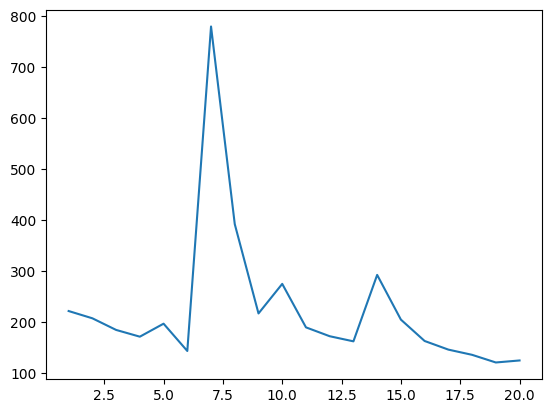

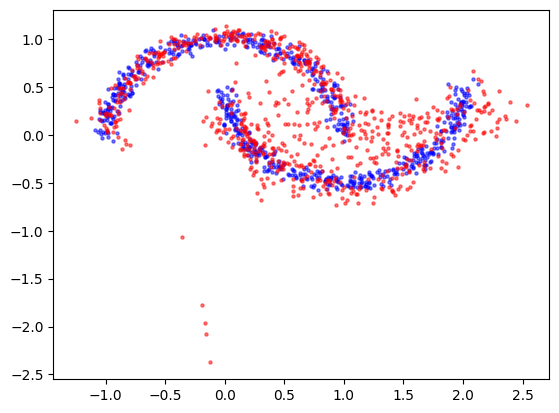

In [ ]:
layers = 5
num_epochs = 20
combined_plots(layers,moons_trainloader, moons_testloader, num_epochs)

275.1247863769531
215.86729431152344
205.35780334472656
212.1279296875
215.10223388671875
200.31410217285156
223.41525268554688
195.0194549560547
210.8679656982422
196.5602569580078
189.7627410888672
194.21302795410156
216.3640594482422
224.5711669921875
197.85940551757812
190.7574462890625
204.6602020263672
196.28677368164062
187.94937133789062
205.80099487304688
193.8172607421875
184.6604766845703
198.71728515625
249.23760986328125
236.67909240722656
197.39886474609375
204.13186645507812
195.3340301513672
196.542724609375
227.9763641357422
216.2696533203125
193.44512939453125
191.7085418701172
192.4873046875
207.51028442382812
189.1932830810547
191.66384887695312
182.80967712402344
190.4161834716797
180.14906311035156
750 750


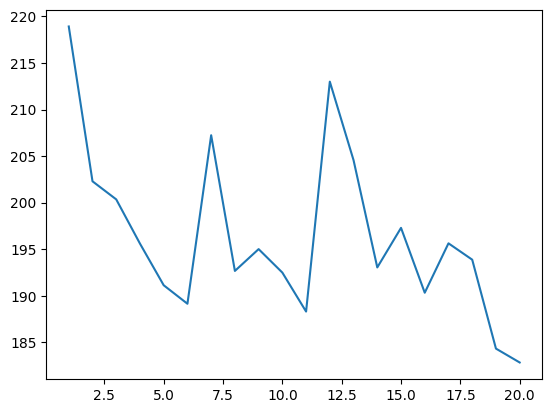

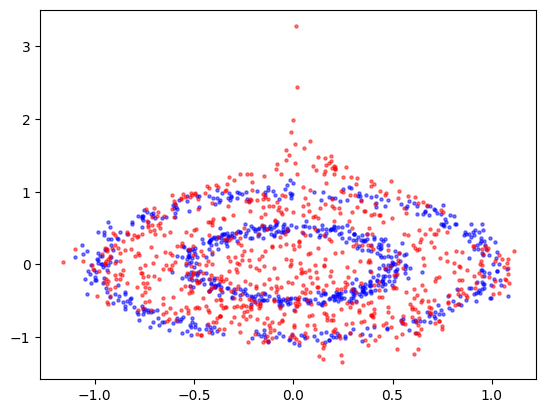

In [ ]:
layers = 5
num_epochs = 20
combined_plots(layers,circles_trainloader, circles_testloader, num_epochs)